In [1]:
import random
import torch
import cv2
import re
import supervision as sv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pathlib import Path
from ultralytics import YOLO
from collections import defaultdict
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tqdm.auto import tqdm

In [4]:
MODEL_PATH = Path("../../runs/detect/train4/weights/best.pt")
VAL_IMAGES_DIR = Path("../../data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("../../videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda


Loaded model from: ../../runs/detect/train4/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball', 3: 'goalkeeper'}


In [6]:
pat = re.compile(r"SNMOT-(\d+)_(\d+)\.jpg$")
clip_to_frames = defaultdict(int)

for p in Path(VAL_IMAGES_DIR).glob("SNMOT-*_*.jpg"):
    m = pat.match(p.name)
    if m:
        clip_id = int(m.group(1))
        clip_to_frames[clip_id] += 1

clip_ids = sorted(clip_to_frames.keys())
print(f"Found {len(clip_ids)} clips in {VAL_IMAGES_DIR}")
print("All clip IDs:")
print(clip_ids)

if not clip_ids:
    raise FileNotFoundError(f"No SNMOT-{{clip}}_{{frame}}.jpg files found in {VAL_IMAGES_DIR}")

CLIP_ID = random.choice(clip_ids)
print(f"Randomly selected existing CLIP_ID = {CLIP_ID}  (frames: {clip_to_frames[CLIP_ID]})")

Found 12 clips in ../../data/tracking/YOLO/images/val
All clip IDs:
[159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]
Randomly selected existing CLIP_ID = 166  (frames: 750)


In [5]:

frame_paths = []
for p in Path(VAL_IMAGES_DIR).glob(f"SNMOT-{CLIP_ID}_*.jpg"):
    m = pat.match(p.name)
    if m:
        frame_no = int(m.group(2))
        frame_paths.append((frame_no, p))

frame_paths.sort(key=lambda x: x[0])
frame_numbers = [fn for fn, _ in frame_paths]
frame_paths = [p for _, p in frame_paths]

print(f"Clip {CLIP_ID}: {len(frame_paths)} frames")



Clip 165: 750 frames


In [6]:
IMG_SIZE = 960  # inference size (change if you want)

names = model.names if hasattr(model, "names") else {}
player_class_ids = {cid for cid, name in names.items() if str(name).lower() == "player"}
if not player_class_ids:
    raise ValueError(f"Couldn't find a 'player' class in model.names: {names}")

player_crops = []   # list[np.ndarray] (BGR crops)
crops_meta = []     # list[dict] aligned with player_crops by index: same order

try:
    from tqdm.auto import tqdm
    it = tqdm(list(zip(frame_numbers, frame_paths)), total=len(frame_paths))
except Exception:
    it = zip(frame_numbers, frame_paths)

for frame_no, img_path in it:
    image_bgr = cv2.imread(str(img_path))
    if image_bgr is None:
        continue

    r0 = model(
        str(img_path),
        imgsz=IMG_SIZE,
        device=device if "device" in globals() else None,
        verbose=False
    )[0]

    det = sv.Detections.from_ultralytics(r0)
    if det.class_id is None or det.confidence is None or len(det) == 0:
        continue

    keep = np.isin(det.class_id, list(player_class_ids))
    det = det[keep]
    if len(det) == 0:
        continue

    h, w = image_bgr.shape[:2]  # should be 1080x1920

    for j, (xyxy, conf, cls_id) in enumerate(zip(det.xyxy, det.confidence, det.class_id)):
        x1, y1, x2, y2 = map(int, xyxy)
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w - 1, x2), min(h - 1, y2)
        if x2 <= x1 or y2 <= y1:
            continue

        crop_bgr = image_bgr[y1:y2, x1:x2]
        player_crops.append(crop_bgr)

        crops_meta.append({
            "clip_id": int(CLIP_ID),
            "frame_number": int(frame_no),
            "frame_path": str(img_path),
            "det_index": int(j),
            "class_id": int(cls_id),
            "class_name": names.get(int(cls_id), str(cls_id)),
            "confidence": float(conf),
            "xyxy": [int(x1), int(y1), int(x2), int(y2)],
            "crop_shape": list(crop_bgr.shape),
        })


n = len(player_crops)

print(f"Total player crops in memory: {n}")


100%|██████████| 750/750 [00:35<00:00, 21.11it/s]

Total player crops in memory: 10324


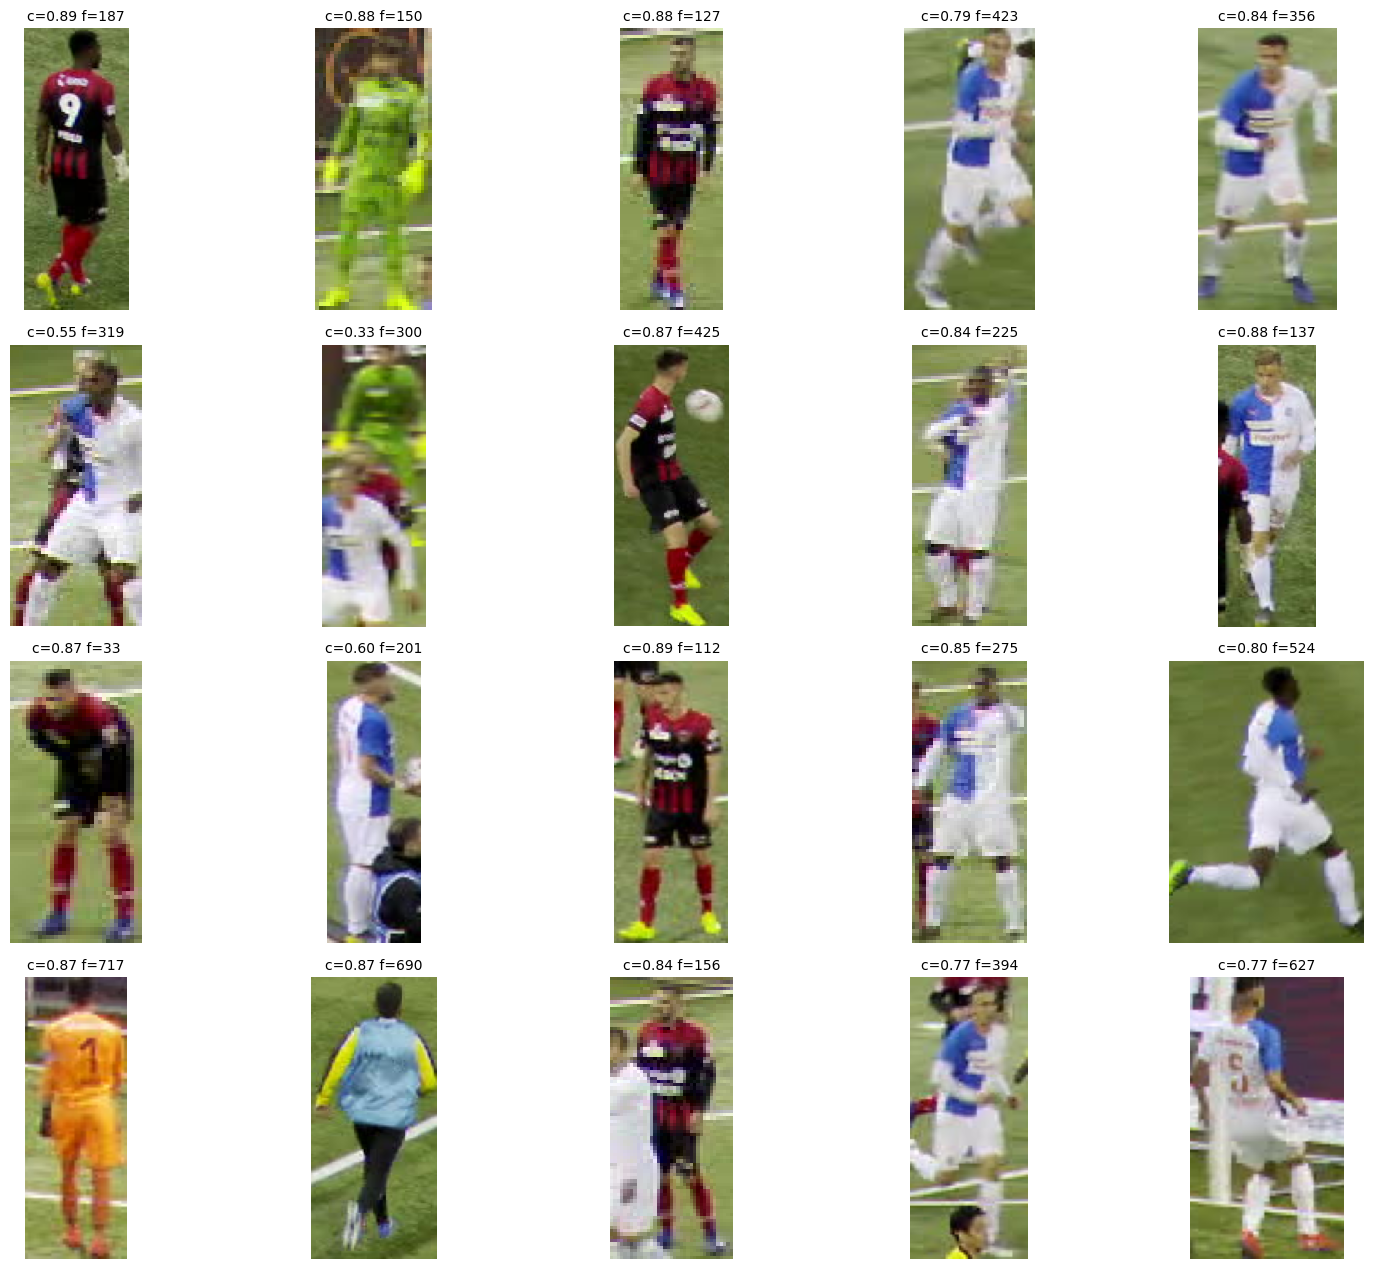

In [7]:
k = min(20, n)
idxs = random.sample(range(n), k)

cols = 5
rows = (k + cols - 1) // cols

plt.figure(figsize=(cols * 3.2, rows * 3.2))
for i, idx in enumerate(idxs, start=1):
    crop_bgr = player_crops[idx]
    crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)

    meta = crops_meta[idx]
    title = f"c={meta['confidence']:.2f} f={meta['frame_number']}"

    ax = plt.subplot(rows, cols, i)
    ax.imshow(crop_rgb)
    ax.set_title(title, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [8]:
DINO_MODEL_ID = "facebook/dinov2-base"

processor = AutoImageProcessor.from_pretrained(DINO_MODEL_ID, use_fast=True)
dino = AutoModel.from_pretrained(DINO_MODEL_ID)

if "device" in globals():
    dino_device = device if isinstance(device, torch.device) else torch.device(device)
else:
    dino_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dino = dino.to(dino_device).eval()
print("DINO device:", dino_device)

DINO device: cuda


In [9]:

def bgr_to_pil(img_bgr):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img_rgb)

BATCH_SIZE = 64

emb_list = []
with torch.no_grad():
    for i in tqdm(range(0, len(player_crops), BATCH_SIZE)):
        batch_pil = [bgr_to_pil(x) for x in player_crops[i:i + BATCH_SIZE]]
        inputs = processor(images=batch_pil, return_tensors="pt")
        inputs = {k: v.to(dino_device) for k, v in inputs.items()}

        outputs = dino(**inputs)                       # outputs.last_hidden_state: (B, 1+P, D)
        emb = outputs.last_hidden_state[:, 0, :]       # CLS token -> (B, D)
        emb = F.normalize(emb, dim=1)                  # cosine-ready
        emb_list.append(emb.cpu())

player_embeddings = torch.cat(emb_list, dim=0).numpy().astype(np.float32)
print("player_embeddings:", player_embeddings.shape) 


100%|██████████| 162/162 [00:52<00:00,  3.06it/s]


player_embeddings: (10324, 768)


In [10]:
import umap

X = player_embeddings  # (N, D)

X3 = umap.UMAP(
    n_components=3,
    n_neighbors=30,
    min_dist=0.0,
    metric="cosine",
    random_state=42,
).fit_transform(X).astype(np.float32)

K = 2 
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
team_labels = kmeans.fit_predict(X3)  # (N,)

for i, m in enumerate(crops_meta):
    m["team_kmeans"] = int(team_labels[i])

counts = np.bincount(team_labels, minlength=K)
print("UMAP 3D:", X3.shape, "| Cluster counts:", {i: int(c) for i, c in enumerate(counts)})

player_embeddings_umap3 = X3


UMAP 3D: (10324, 3) | Cluster counts: {0: 5884, 1: 4440}


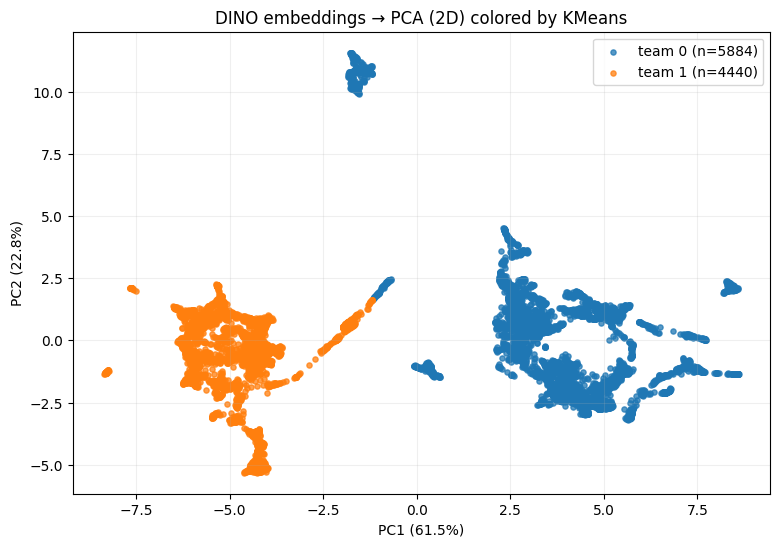

In [11]:

X = player_embeddings_umap3
pca = PCA(n_components=2, random_state=42)
X2 = pca.fit_transform(X)

plt.figure(figsize=(9, 6))
for k in range(np.max(team_labels) + 1):
    mask = (team_labels == k)
    plt.scatter(X2[mask, 0], X2[mask, 1], s=14, alpha=0.75, label=f"team {k} (n={mask.sum()})")

plt.title("DINO embeddings → PCA (2D) colored by KMeans")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()


Random frame: SNMOT-165_000294.jpg (frame_number=294)
Plotted 16 players with team labels.


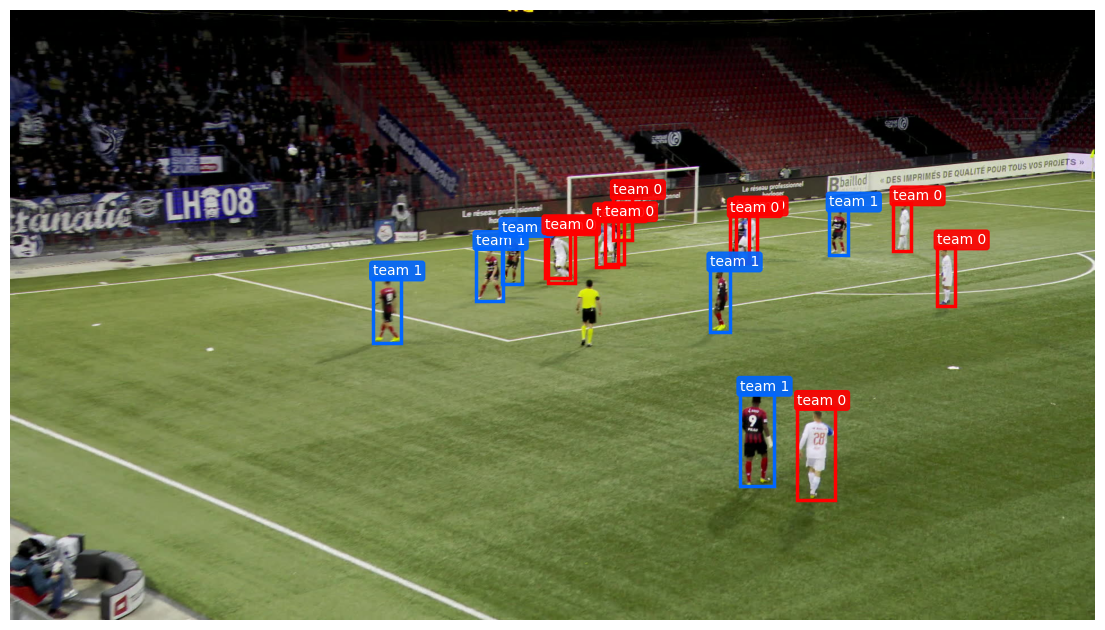

In [12]:
frame_idx = random.randrange(len(frame_paths))
frame_no = frame_numbers[frame_idx]
frame_path = frame_paths[frame_idx]

img_bgr = cv2.imread(str(frame_path))
if img_bgr is None:
    raise FileNotFoundError(f"Couldn't read: {frame_path}")

idxs = [i for i, m in enumerate(crops_meta) if m["frame_number"] == frame_no]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 8))
plt.imshow(img_rgb)
ax = plt.gca()
ax.axis("off")

team_colors = {
    0: (1.0, 0.0, 0.0),
    1: (0.0, 0.4, 1.0),
}

for i in idxs:
    m = crops_meta[i]
    x1, y1, x2, y2 = m["xyxy"]
    team = int(m.get("team_kmeans", -1))

    color = team_colors.get(team, (1.0, 1.0, 0.0))  # unknown -> yellow
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, linewidth=2.5, edgecolor=color)
    ax.add_patch(rect)

    ax.text(
        x1, max(0, y1 - 6),
        f"team {team}",
        fontsize=10,
        color="white",
        bbox=dict(boxstyle="round,pad=0.2", facecolor=color, edgecolor=color, alpha=0.9),
    )

print(f"Random frame: {frame_path.name} (frame_number={frame_no})")
print(f"Plotted {len(idxs)} players with team labels.")
plt.show()


In [13]:

OUT_PATH = Path(f"clip_{CLIP_ID}_teams.mp4")

img0_bgr = cv2.imread(str(frame_paths[0]))
h, w = img0_bgr.shape[:2]

fps = float(globals().get("FPS", 25))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(OUT_PATH), fourcc, fps, (w, h))

team_colors_bgr = {
    0: (0, 0, 255),
    1: (255, 128, 0),
}
unknown_color_bgr = (0, 255, 255)

# Build fast index by frame_number -> list of meta indices
frame_to_idxs = {}
for i, m in enumerate(crops_meta):
    frame_to_idxs.setdefault(m["frame_number"], []).append(i)

for frame_no, frame_path in tqdm(list(zip(frame_numbers, frame_paths)), total=len(frame_paths)):
    frame_bgr = cv2.imread(str(frame_path))
    if frame_bgr is None:
        continue

    idxs = frame_to_idxs.get(frame_no, [])
    for i in idxs:
        m = crops_meta[i]
        x1, y1, x2, y2 = m["xyxy"]
        team = int(m.get("team_kmeans", -1))
        color = team_colors_bgr.get(team, unknown_color_bgr)

        cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), color, 2)

        label = f"team {team}"
        (tw, th), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
        y_text = max(0, y1 - 6)
        cv2.rectangle(
            frame_bgr,
            (x1, max(0, y_text - th - baseline - 4)),
            (x1 + tw + 6, y_text + 2),
            color,
            -1
        )
        cv2.putText(
            frame_bgr,
            label,
            (x1 + 3, y_text),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.6,
            (255, 255, 255),
            2,
            cv2.LINE_AA
        )

    writer.write(frame_bgr)

writer.release()
print("Saved:", OUT_PATH)


  6%|▋         | 48/750 [00:01<00:24, 28.94it/s]

100%|██████████| 750/750 [00:24<00:00, 31.12it/s]

Saved: clip_165_teams.mp4
